## Machine Learning Models for forecasting ETF price

### ARIMA Model
**Definition**: ARIMA, short for Autoregressive Integrated Moving Average, is a time series forecasting method used to understand and predict future data points based on historical patterns.

**Components**: ARIMA models consist of three main components:

- **Autoregressive** (AR): This component represents the relationship between an observation and a number of lagged observations.
- **Integrated** (I): This component represents the differencing of raw observations to make the time series stationary.
- **Moving Average** (MA): This component represents the dependency between an observation and a residual error from a moving average model applied to lagged observations.
- **Parameters**: ARIMA models are defined by three parameters:

- **p (AR order)**: The number of lag observations included in the model.
- **d (I order)**: The degree of differencing needed to make the time series stationary.
- **q (MA order)**: The size of the moving average window.

**Model Fitting**: In Python, libraries like statsmodels and pmdarima offer tools to fit ARIMA models to time series data efficiently. These libraries provide functions to automatically select optimal parameters through techniques like grid search or use of Akaike Information Criterion (AIC).

**Forecasting**: Once the model is fitted to historical data, it can be used to forecast future values based on the identified patterns and relationships in the data.

**Evaluation**: It's important to evaluate the performance of the ARIMA model using metrics such as Mean Squared Error (MSE), Root Mean Squared Error (RMSE), or Mean Absolute Error (MAE) to assess how well it predicts unseen data.

**Application**: ARIMA models find applications in various domains including finance, economics, weather forecasting, and demand forecasting, among others, where understanding and predicting time-dependent data patterns are crucial.

#### Write about LSTM models

## 1. Importing the Modules

In [291]:
# !pip install pmdarima

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import date as dt
import matplotlib.pyplot as plt
import yfinance as yf
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score,mean_absolute_percentage_error

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM,Dropout
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

c:\Users\hp\anaconda3\lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


## 2. Fetch the historical data using Yahoo Finance Python package - yfinance

In [6]:
# Fetch historical data using yfinance
start_date = "2015-01-01"
end_date = dt.date.today()
symbol = "VOO"

data = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [7]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,189.289993,189.720001,187.259995,188.399994,159.705673,1865000
2015-01-05,187.259995,187.410004,184.660004,185.089996,156.899780,2734700
2015-01-06,185.369995,185.880005,182.360001,183.270004,155.357025,2245300
2015-01-07,184.729996,185.910004,184.229996,185.559998,157.298233,2305600
2015-01-08,187.130005,189.050003,187.070007,188.820007,160.061722,1740600
...,...,...,...,...,...,...
2024-03-19,472.200012,475.739990,471.290009,475.600006,475.600006,4550200
2024-03-20,475.540009,480.019989,474.929993,479.750000,479.750000,6179400
2024-03-21,482.619995,483.239990,481.209991,481.350006,481.350006,5044700


## 3. Understanding our data - EDA

In [8]:
# Display basic information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2322 entries, 2015-01-02 to 2024-03-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2322 non-null   float64
 1   High       2322 non-null   float64
 2   Low        2322 non-null   float64
 3   Close      2322 non-null   float64
 4   Adj Close  2322 non-null   float64
 5   Volume     2322 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 127.0 KB


In [9]:
# Display summary statistics
print(data.describe())

              Open         High          Low        Close    Adj Close  \
count  2322.000000  2322.000000  2322.000000  2322.000000  2322.000000   
mean    290.949992   292.502924   289.254974   291.000818   273.140702   
std      83.221202    83.730223    82.710301    83.264130    90.218304   
min     167.259995   168.720001   165.960007   167.699997   145.174881   
25%     218.459995   219.342499   217.299995   218.562500   193.600189   
50%     267.264999   268.214996   265.940002   267.164993   247.171211   
75%     370.444992   373.177498   366.964989   369.997490   361.913452   
max     482.619995   483.239990   481.209991   481.350006   481.350006   

             Volume  
count  2.322000e+03  
mean   3.513924e+06  
std    2.343807e+06  
min    5.890000e+05  
25%    1.981275e+06  
50%    2.976100e+06  
75%    4.310175e+06  
max    2.466930e+07  


In [10]:
#Check for missing values
print(data.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [11]:
#check for duplicates
data.duplicated().sum()

0

In [12]:
def univariate_plot(value, first_title, second_title, third_title , box_plot_variable = None, plot_1_label=None, plot_2_label=None):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Adjust the figsize for best fit

    axs[0].hist(value, color='black', edgecolor='white')  # Data for the first plot
    axs[0].set_title(first_title)

    axs[1].set_title(second_title)
    axs[1].plot(value,color='black')  # Data for the second plot
    axs[1].tick_params(axis='x', rotation=45)

    axs[2].boxplot(value)  # Data for the third plot
    axs[2].set_title(third_title)
    axs[2].set_xticklabels([box_plot_variable])

    plt.tight_layout()
    plt.show()

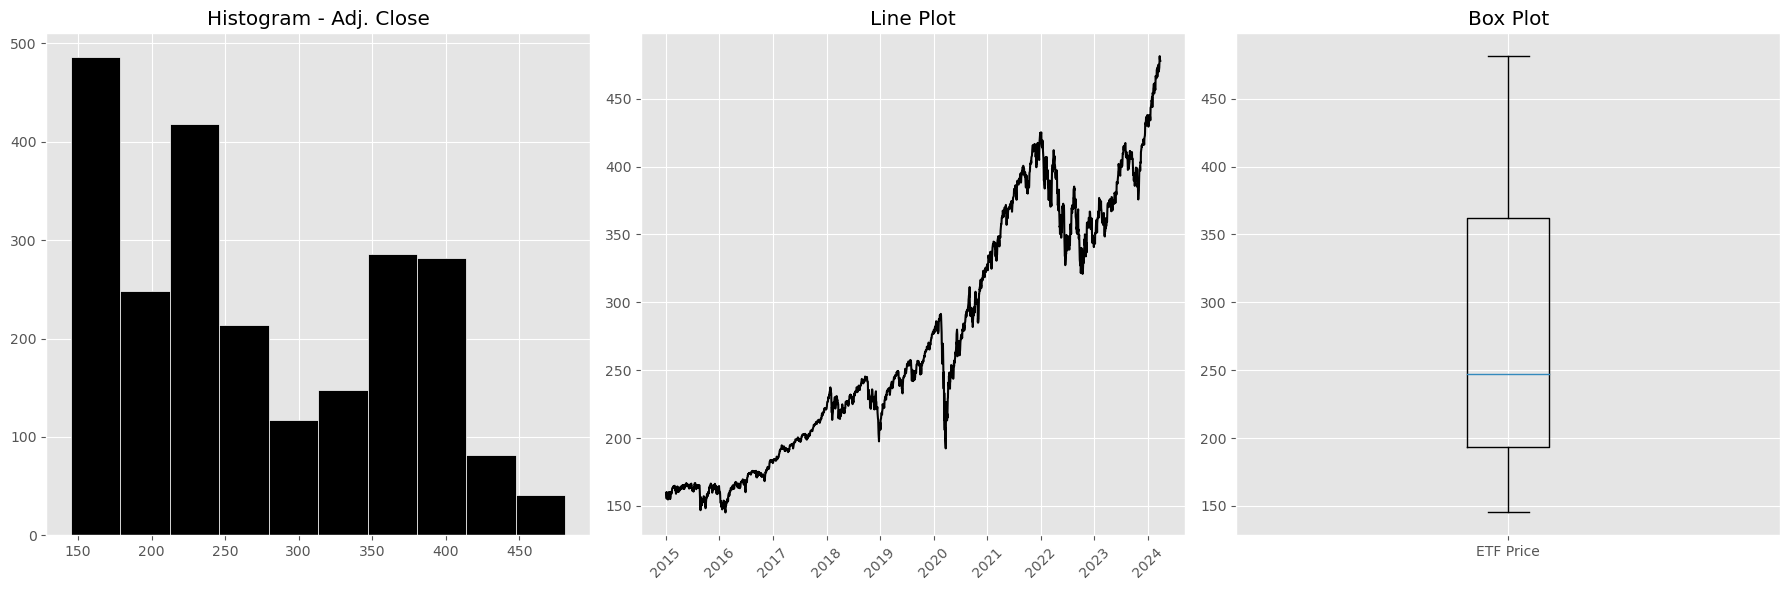

In [13]:
univariate_plot(data['Adj Close'],'Histogram - Adj. Close', 'Line Plot', 'Box Plot', 'ETF Price')

## 4. Splitting the Series into Test and Train

In [370]:
# Splitting data into train and test set

#all data points except last 20
train = data['Adj Close'][:-20]

#last 5 data points
test = data['Adj Close'][-20:]

## 5. Use Auto ARIMA package to find the best p,d,q values

In [371]:
# Auto ARIMA to find best p,d,q values
model_arima = auto_arima(train, 
                   seasonal=False,
                   trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11748.153, Time=1.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11837.343, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11822.471, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11823.662, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11839.243, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11823.266, Time=0.63 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11823.480, Time=0.54 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=11749.536, Time=1.68 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=11809.215, Time=2.84 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11822.196, Time=0.33 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=11822.970, Time=0.86 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11823.811, Time=0.88 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.04 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=11750.571, Time=0.88 sec

Best model:  ARIMA(2,1,2

In [372]:
model_arima

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

## 6. Fit the Model and get forecasts

In [373]:
model_arima.order

(2, 1, 2)

In [374]:
# Convert date index to datetime
train.index = pd.to_datetime(train.index)

# Set frequency for the date index
train = train.asfreq(freq='B')

# Fit ARIMA model with best parameters
arima_model = ARIMA(train, order=model_arima.order)
arima_fit = arima_model.fit()

# Forecasting with number of steps taken from test dataframe with 95% conf interval
forecast = arima_fit.get_forecast(steps=len(test),alpha = 0.05,)

In [375]:
# Extract forecasted values
forecast_values = forecast.predicted_mean

# Extract confidence intervals
conf_int = forecast.conf_int()

# Combine forecast and confidence intervals into one DataFrame
forecast_data = pd.concat([forecast_values, conf_int], axis=1)
forecast_data.columns = ['Forecast', 'Lower CI', 'Upper CI']

forecast_data

,Forecast,Lower CI,Upper CI
2024-02-16,461.583330,455.481893,467.684767
2024-02-19,461.624764,453.320095,469.929432
2024-02-20,461.386979,451.215002,471.558956
2024-02-21,461.762114,450.022287,473.501940
2024-02-22,461.318536,448.278329,474.358742
2024-02-23,461.762254,447.405243,476.119265
2024-02-26,461.377140,445.968282,476.785998
2024-02-27,461.660898,445.117178,478.204617
2024-02-28,461.501840,444.023587,478.980092
2024-02-29,461.532632,443.074552,479.990711


## 7. Visualising the Forecast with Upper and Lower Limits
### Inclusive of Evaluation Metrics

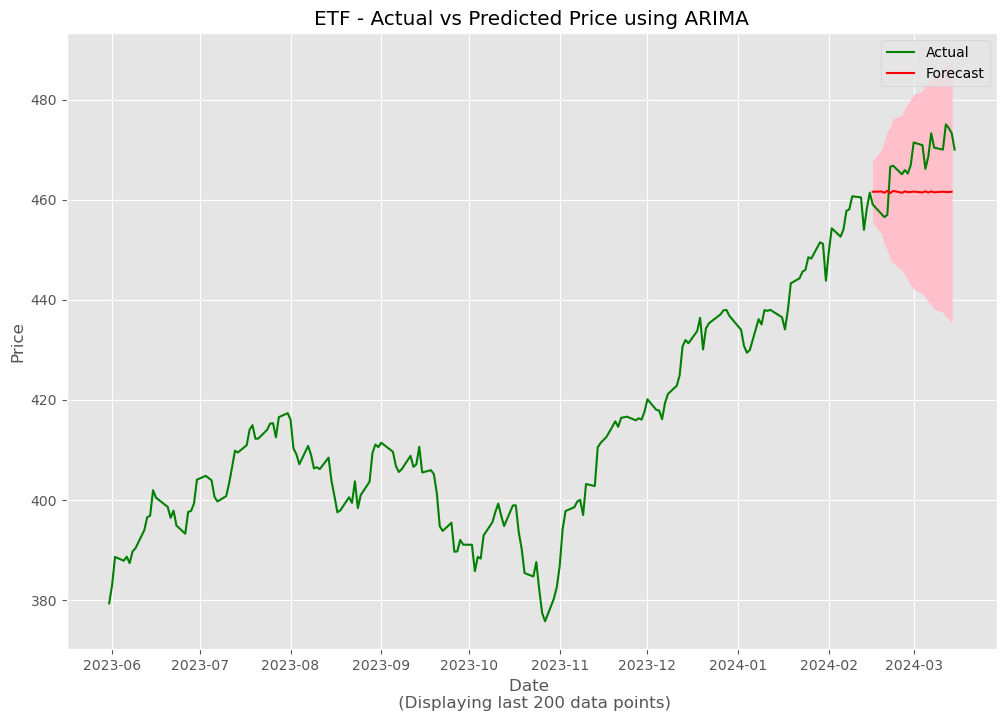

In [376]:
# plot the  data
plt.figure(figsize=(12,8))

n = 200

plot_data = data.tail(n).copy()
plt.plot(plot_data.index, plot_data['Adj Close'],color='g', label='Actual')
 
# plot your mean predictions
plt.plot(forecast_data.index, forecast_data['Forecast'], color='r', label='Forecast')
 
# shade the area between your confidence limits
plt.fill_between(forecast_data.index, forecast_data['Lower CI'],
               forecast_data['Upper CI'], color='pink')
 
# set labels, legends and show plot
plt.xlabel(f'Date \n (Displaying last {n} data points)')
plt.ylabel('Price')
plt.title('ETF - Actual vs Predicted Price using ARIMA')
plt.legend()
plt.show()

In [377]:
def evaluation_metrics(actual_values, forecast_values):
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(actual_values, forecast_values)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(actual_values, forecast_values)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs(forecast_values - actual_values) / np.abs(actual_values)) * 100

    r = r2_score(actual_values, forecast_values)

    # Print the performance metrics
    print(f'Mean Squared Error (MSE): {mse:.2f}')
    print(f'Mean Absolute Error (MAE): {mae:.2f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}')
    print(f'R-Squared value: {r:.2f}')

In [378]:
evaluation_metrics(test,forecast_data.Forecast)

Mean Squared Error (MSE): 63.72
Mean Absolute Error (MAE): 7.27
Root Mean Squared Error (RMSE): 7.98
Mean Absolute Percentage Error (MAPE): 1.54
R-Squared value: -1.37


- **Mean Squared Error (MSE):** The average of the squared differences between the forecasted and actual values, providing a measure of the average squared deviation from the true values.
- **Mean Absolute Error (MAE):** The average of the absolute differences between the forecasted and actual values, providing a measure of the average magnitude of errors.
- **Root Mean Squared Error (RMSE)**: The square root of the MSE, providing a measure of the average magnitude of errors with the same units as the original data.
- **Mean Absolute Percentage Error (MAPE)**: The average of the absolute percentage differences between the forecasted and actual values, expressed as a percentage of the actual values, providing a measure of the accuracy of the forecast relative to the actual values.

In this case:

- MSE is 151.29, on average, the squared deviation of the forecasted values from the actual values is 151.29.
- MAE is 10.43,  on average, the absolute difference between the forecasted values and the actual values is 10.43.
- RMSE is 12.30, on average, the forecasted values deviate from the actual values by approximately 12.30 units.
- MAPE is 2.17%, on average, the forecasted values deviate from the actual values by approximately 2.17% of the actual values.

These metrics provide insights into the accuracy and performance of the forecasting model.

Lower values of these metrics indicate better performance.

## 8. Creating the LSTM model

In [379]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,189.289993,189.720001,187.259995,188.399994,159.705673,1865000
2015-01-05,187.259995,187.410004,184.660004,185.089996,156.899780,2734700
2015-01-06,185.369995,185.880005,182.360001,183.270004,155.357025,2245300
2015-01-07,184.729996,185.910004,184.229996,185.559998,157.298233,2305600
2015-01-08,187.130005,189.050003,187.070007,188.820007,160.061737,1740600
...,...,...,...,...,...,...
2024-03-11,469.200012,470.459991,467.390015,470.000000,470.000000,5323900
2024-03-12,471.920013,475.549988,469.570007,475.029999,475.029999,4811000
2024-03-13,475.309998,475.470001,472.899994,474.309998,474.309998,3544500


### 8.1 - Setting up Early Stop

In [380]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10,  verbose=1, mode='min')
callbacks_list = [earlystop]

### 8.2 - Building the Model

In [381]:
#Build and train the model
def fit_model(train,val,timesteps,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    # model = Sequential()
    # model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
    #                activation = 'relu'))
    # for i in range(len(hl)-1):        
    #     model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    # model.add(LSTM(hl[-1],activation = 'relu'))
    # model.add(Dense(1))
    # model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')
    # #print(model.summary())

    model=Sequential()
    model.add(LSTM(64,return_sequences=True,input_shape = (X_train.shape[1],X_train.shape[2])))
    model.add(Dropout(0.1))
    model.add(LSTM(64,return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(64))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')
    model.summary()
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 1,
                        shuffle = False, callbacks=callbacks_list)
    # model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

### 8.3 - Evaluating the model

In [382]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    mae = mean_absolute_error(Y_test,Y_hat)
    # mape = mean_absolute_percentage_error(Y_test,Y_hat)
    mape = np.mean(np.abs(Y_hat - Y_test) / np.abs(Y_test)) * 100
    r = r2_score(Y_test,Y_hat)
    return mse, rmse,mae,mape, r, Y_test, Y_hat

### 8.4 - Plotting the graph for Predictions and Errors

In [383]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.figure(figsize=(12,8))
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('ETF - Actual vs Predicted using Multivariate-LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [384]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.figure(figsize=(12,8))
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.title('Training and Validation loss using Early stopping')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

### 8.5 - Selecting the data for the LSTM model

In [385]:
# Extracting the data for the model from the actual data
series = data[['Adj Close','Open','High','Low','Volume']]
print(series.shape)
print(series.tail())

(2316, 5)
             Adj Close        Open        High         Low   Volume
Date                                                               
2024-03-11  470.000000  469.200012  470.459991  467.390015  5323900
2024-03-12  475.029999  471.920013  475.549988  469.570007  4811000
2024-03-13  474.309998  475.309998  475.470001  472.899994  3544500
2024-03-14  473.269989  475.160004  475.329987  470.450012  5153000
2024-03-15  470.010010  470.410004  471.779999  468.720001  6802400


### 8.6 - Split the data into Train, Validate and Test

In [386]:
num_rows = len(series)  # Total number of rows mentioned
train_split = int(num_rows * 0.8)  # 80% for training
val_split = train_split + int(num_rows * 0.1)  # Next 10% for validation

# Creating the split datasets based on calculated indices
train_data = series.iloc[:train_split]
validation_data = series.iloc[train_split:val_split]
test_data = series.iloc[val_split:]

# Output the index ranges for each dataset to verify the sequential split
(train_data.index.min(), train_data.index.max()), (validation_data.index.min(), validation_data.index.max()), (test_data.index.min(), test_data.index.max())

((Timestamp('2015-01-02 00:00:00'), Timestamp('2022-05-10 00:00:00')),
 (Timestamp('2022-05-11 00:00:00'), Timestamp('2023-04-12 00:00:00')),
 (Timestamp('2023-04-13 00:00:00'), Timestamp('2024-03-15 00:00:00')))

In [387]:
train_data

,Adj Close,Open,High,Low,Volume
Date,,,,,
2015-01-02,159.705673,189.289993,189.720001,187.259995,1865000
2015-01-05,156.899780,187.259995,187.410004,184.660004,2734700
2015-01-06,155.357025,185.369995,185.880005,182.360001,2245300
2015-01-07,157.298233,184.729996,185.910004,184.229996,2305600
2015-01-08,160.061737,187.130005,189.050003,187.070007,1740600
...,...,...,...,...,...
2022-05-04,382.986267,383.350006,394.929993,380.279999,7367500
2022-05-05,369.535034,390.220001,390.309998,376.350006,10477300
2022-05-06,367.213867,378.010010,381.279999,372.950012,7959600


In [388]:
validation_data

,Adj Close,Open,High,Low,Volume
Date,,,,,
2022-05-11,350.538177,365.970001,371.359985,360.269989,8026900
2022-05-12,350.266235,357.839996,363.750000,354.019989,7679200
2022-05-13,358.531219,364.730011,370.579987,363.640015,5377400
2022-05-16,357.249237,367.709991,371.350006,365.450012,4719800
2022-05-17,364.397339,373.660004,375.559998,370.079987,4513300
...,...,...,...,...,...
2023-04-05,370.108521,374.709991,375.420013,372.890015,3227700
2023-04-06,371.521667,373.670013,376.190002,372.720001,3076200
2023-04-10,371.926788,373.549988,376.390015,372.959991,2671100


In [397]:
test_data

,Adj Close,Open,High,Low,Volume
Date,,,,,
2023-04-13,375.296631,375.910004,380.170013,375.440002,2680900
2023-04-14,374.525848,379.269989,381.329987,376.720001,2981700
2023-04-17,375.800629,378.839996,380.320007,377.679993,2721000
2023-04-18,376.057587,381.839996,381.920013,379.239990,3019300
2023-04-19,376.037811,378.730011,381.329987,378.670013,2671300
...,...,...,...,...,...
2024-03-11,470.000000,469.200012,470.459991,467.390015,5323900
2024-03-12,475.029999,471.920013,475.549988,469.570007,4811000
2024-03-13,474.309998,475.309998,475.470001,472.899994,3544500


### 8.7 - Normalize the data for feeding into the model

In [390]:
#Normalising the data for LSTM model
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(validation_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(1852, 5) (231, 5) (233, 5)


### 8.8 - Setup Hyperparameter and Train the model on the Train and Validation set

In [391]:
# Setting up the hyper-parameters for the LSTM model
timesteps = 30
batch_size = 64
num_epochs = 250

In [392]:
# Training the model on the train and validation set
model,train_error,val_error = fit_model(train,val,timesteps,batch_size,num_epochs)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 64)            17920     
                                                                 
 dropout_6 (Dropout)         (None, 30, 64)            0         
                                                                 
 lstm_7 (LSTM)               (None, 30, 64)            33024     
                                                                 
 dropout_7 (Dropout)         (None, 30, 64)            0         
                                                                 
 lstm_8 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

### 8.9 - Plot the Train and Validation error with Early Stopping

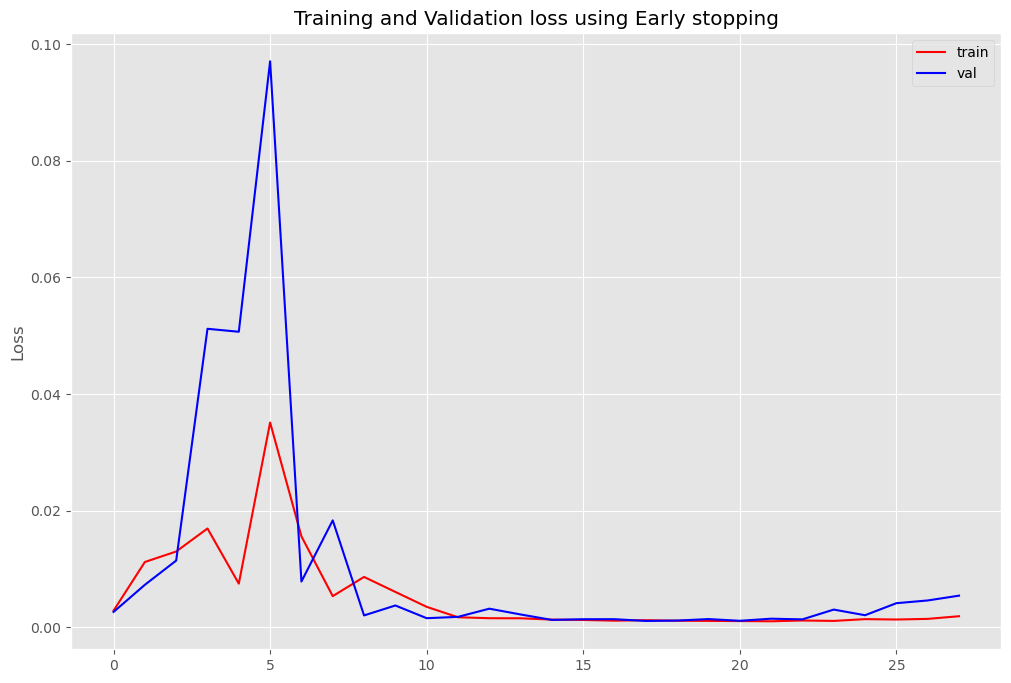

In [393]:
plot_error(train_error,val_error)

### 8.10 - Calculate the error metrics and R-squared values

In [399]:
## Calculate the error metrics for the predictions

mse, rmse,mae,mape, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAE = {}'.format(mae))
print('MAPE = {:.2f} %'.format(mape))
print('R-Squared Score = {}'.format(r2_value))

7/7 [==============================] - 0s 13ms/step
MSE = 0.001948115244820545
RMSE = 0.04413745852244491
MAE = 0.03646377014300427
MAPE = 8.76 %
R-Squared Score = 0.7687873677104093


### 8.11 - Plot the actual vs predicted values of the normalized data

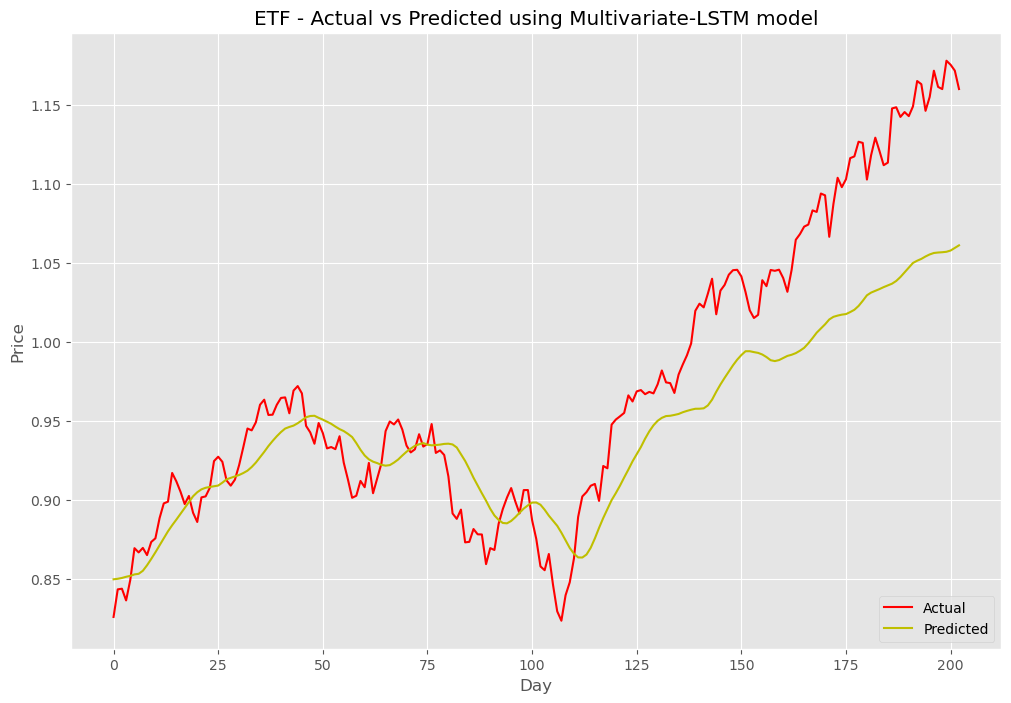

In [326]:
plot_data(true,predicted)

In [327]:
true_scaled = true.reshape(-1, 1)  # Reshaping is required if true is a 1D array
predicted_scaled = predicted.reshape(-1, 1)  # Reshaping is required if predicted is a 1D array

#### The below code is for rescaling the data back to actual value from normalized data

In [328]:
train_data.shape

(1852, 5)

In [329]:
# Create dummy arrays to match the shape of the original dataset
true_dummy = np.zeros((true_scaled.shape[0], train_data.shape[1]))
predicted_dummy = np.zeros((predicted_scaled.shape[0], train_data.shape[1]))

# Replace the first column (assuming 'Close' is the first feature) with your true and predicted values
true_dummy[:, 0] = true_scaled.ravel()  # Flatten true_scaled if it's not already 1D
predicted_dummy[:, 0] = predicted_scaled.ravel()

# Inverse transform using the dummy arrays
true_inverse = sc.inverse_transform(true_dummy)[:, 0]  # Extracting only the 'Close' prices after inverse transform
predicted_inverse = sc.inverse_transform(predicted_dummy)[:, 0]

# Now, true_inverse and predicted_inverse contain the inverse-transformed 'Close' prices
print("True Values:\n", true_inverse)
print("Predicted Values:\n", predicted_inverse)

True Values:
 [376.43313599 381.32479858 381.44338989 379.36813354 383.00479126
 388.62774658 387.87670898 388.67715454 387.40234375 389.72467041
 390.37689209 393.96417236 396.56314087 396.86953735 401.95883179
 400.47650146 398.62854004 396.4446106  397.88739014 394.9029541
 393.27236938 397.63046265 397.80831909 399.33221436 404.0645752
 404.83840942 403.93557739 400.64175415 399.70922852 400.78067017
 403.35025024 406.5249939  409.83862305 409.51119995 410.93981934
 414.05505371 414.94793701 412.23950195 412.28909302 414.03518677
 415.25549316 415.35470581 412.53710938 416.55514526 417.35876465
 416.06903076 410.30490112 409.14413452 407.14007568 410.81085205
 409.03500366 406.31661987 406.55474854 406.17773438 408.46951294
 403.78674316 400.80053711 397.55633545 397.92340088 400.55249023
 399.431427   403.73718262 398.36987305 401.00888062 403.64785767
 409.38226318 411.08865356 410.56283569 411.43588257 409.64019775
 406.81268311 405.60229492 406.15789795 408.82662964 406.6340942

### 8.12 - Plot the actual vs predicted values of the actual data

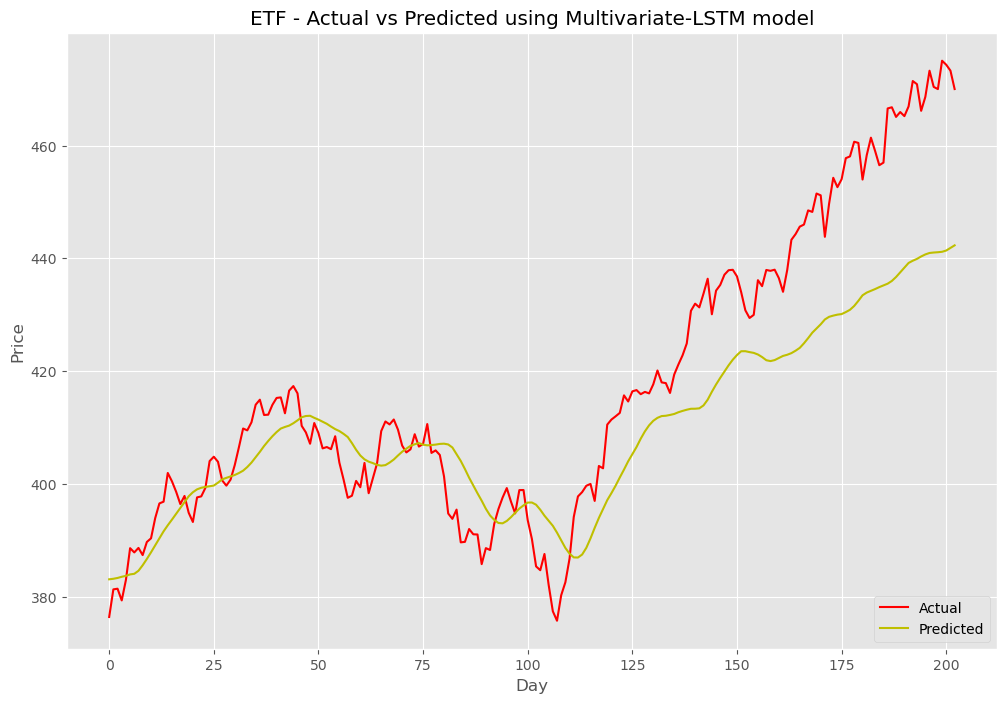

In [330]:
plot_data(true_inverse,predicted_inverse)

## 9. Creating the XGBoost model

In [331]:
import os
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from finta import TA
import plotly.graph_objects as go

In [332]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,189.289993,189.720001,187.259995,188.399994,159.705673,1865000
2015-01-05,187.259995,187.410004,184.660004,185.089996,156.899780,2734700
2015-01-06,185.369995,185.880005,182.360001,183.270004,155.357025,2245300
2015-01-07,184.729996,185.910004,184.229996,185.559998,157.298233,2305600
2015-01-08,187.130005,189.050003,187.070007,188.820007,160.061737,1740600
...,...,...,...,...,...,...
2024-03-11,469.200012,470.459991,467.390015,470.000000,470.000000,5323900
2024-03-12,471.920013,475.549988,469.570007,475.029999,475.029999,4811000
2024-03-13,475.309998,475.470001,472.899994,474.309998,474.309998,3544500


In [333]:
data_xgb = data.copy()
data_xgb

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,189.289993,189.720001,187.259995,188.399994,159.705673,1865000
2015-01-05,187.259995,187.410004,184.660004,185.089996,156.899780,2734700
2015-01-06,185.369995,185.880005,182.360001,183.270004,155.357025,2245300
2015-01-07,184.729996,185.910004,184.229996,185.559998,157.298233,2305600
2015-01-08,187.130005,189.050003,187.070007,188.820007,160.061737,1740600
...,...,...,...,...,...,...
2024-03-11,469.200012,470.459991,467.390015,470.000000,470.000000,5323900
2024-03-12,471.920013,475.549988,469.570007,475.029999,475.029999,4811000
2024-03-13,475.309998,475.470001,472.899994,474.309998,474.309998,3544500


In [334]:
data_xgb['EMA_9'] = data_xgb['Adj Close'].ewm(9).mean().shift()
data_xgb['SMA_5'] = data_xgb['Adj Close'].rolling(5).mean().shift()
data_xgb['SMA_10'] = data_xgb['Adj Close'].rolling(10).mean().shift()
data_xgb['SMA_15'] = data_xgb['Adj Close'].rolling(15).mean().shift()
data_xgb['SMA_30'] = data_xgb['Adj Close'].rolling(30).mean().shift()

In [335]:
data_xgb

,Open,High,Low,Close,Adj Close,Volume,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30
Date,,,,,,,,,,,
2015-01-02,189.289993,189.720001,187.259995,188.399994,159.705673,1865000,NaN,NaN,NaN,NaN,NaN
2015-01-05,187.259995,187.410004,184.660004,185.089996,156.899780,2734700,159.705673,NaN,NaN,NaN,NaN
2015-01-06,185.369995,185.880005,182.360001,183.270004,155.357025,2245300,158.228887,NaN,NaN,NaN,NaN
2015-01-07,184.729996,185.910004,184.229996,185.559998,157.298233,2305600,157.169160,NaN,NaN,NaN,NaN
2015-01-08,187.130005,189.050003,187.070007,188.820007,160.061737,1740600,157.206692,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-11,469.200012,470.459991,467.390015,470.000000,470.000000,5323900,464.546147,469.858002,468.385999,465.981333,460.187669
2024-03-12,471.920013,475.549988,469.570007,475.029999,475.029999,4811000,465.091532,469.684003,468.878998,466.712667,460.913335
2024-03-13,475.309998,475.470001,472.899994,474.309998,474.309998,3544500,466.085379,471.460004,469.788998,467.947333,461.698002


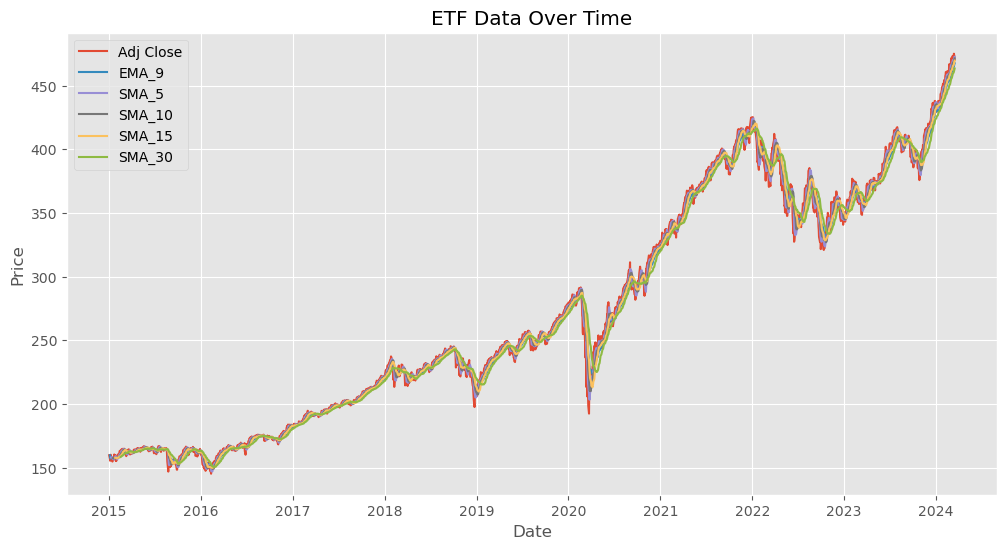

In [336]:
df_plot = data_xgb[['Adj Close','EMA_9','SMA_5','SMA_10','SMA_15','SMA_30']]

plt.figure(figsize=(12, 6))
for column in df_plot.columns:
    plt.plot(df_plot.index, df_plot[column], label=column)
    
plt.legend()
plt.title('ETF Data Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

Create the Technical Analysis data

`RSI (Relative Strength Index)`: RSI is a momentum oscillator that measures the speed and change of price movements. It oscillates between 0 and 100 and is typically used to identify overbought or oversold conditions in a traded asset. An RSI above 70 is generally considered overbought, whereas an RSI below 30 is considered oversold. This can signal potential reversals in price direction.

`ATR (Average True Range)`: ATR is a volatility indicator that measures the degree of price volatility by decomposing the entire range of an asset for that period. It is not a directional indicator but rather gives traders an idea of how much an asset moves, on average, over a given period. This can be useful for setting stop-loss orders or for understanding the volatility of an asset.

`BBWidth (Bollinger Band Width)`: Bollinger Bands are a popular volatility indicator that consists of a middle line (typically a simple moving average) with two bands (upper and lower) plotted two standard deviations away from the middle line. The BBWidth measures the distance (or width) between these upper and lower bands. A widening BBWidth indicates increasing volatility, while a narrowing BBWidth suggests decreasing volatility.

`Williams %R (Williams Percent Range)`: Williams %R is a momentum indicator that measures overbought and oversold levels. It is similar to the RSI but uses a different calculation method. The indicator moves between 0 and -100, with readings above -20 typically indicating overbought conditions and readings below -80 indicating oversold conditions. This can signal potential reversals in the market.

In [337]:
data_xgb['RSI'] = TA.RSI(data_xgb)
data_xgb['ATR'] = TA.ATR(data_xgb)
data_xgb['BBWidth'] = TA.BBWIDTH(data_xgb)
data_xgb['Williams'] = TA.WILLIAMS(data_xgb)

Create a new Target column which is the Adj. Close price for next day

In [338]:
data_xgb['Target'] = data_xgb['Adj Close'].shift(-1)

In [339]:
data_xgb

,Open,High,Low,Close,Adj Close,Volume,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,ATR,BBWidth,Williams,Target
Date,,,,,,,,,,,,,,,,
2015-01-02,189.289993,189.720001,187.259995,188.399994,159.705673,1865000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156.899780
2015-01-05,187.259995,187.410004,184.660004,185.089996,156.899780,2734700,159.705673,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,155.357025
2015-01-06,185.369995,185.880005,182.360001,183.270004,155.357025,2245300,158.228887,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,157.298233
2015-01-07,184.729996,185.910004,184.229996,185.559998,157.298233,2305600,157.169160,NaN,NaN,NaN,NaN,33.508757,NaN,NaN,NaN,160.061737
2015-01-08,187.130005,189.050003,187.070007,188.820007,160.061737,1740600,157.206692,NaN,NaN,NaN,NaN,56.074320,NaN,NaN,NaN,158.713867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-11,469.200012,470.459991,467.390015,470.000000,470.000000,5323900,464.546147,469.858002,468.385999,465.981333,460.187669,62.026926,4.331423,0.048106,-27.753273,475.029999
2024-03-12,471.920013,475.549988,469.570007,475.029999,475.029999,4811000,465.091532,469.684003,468.878998,466.712667,460.913335,66.967160,4.507137,0.051103,-9.084340,474.309998
2024-03-13,475.309998,475.470001,472.899994,474.309998,474.309998,3544500,466.085379,471.460004,469.788998,467.947333,461.698002,65.650541,3.950710,0.048151,-16.061282,473.269989


In [340]:
# dropping the N/A datas from the dataframe.
data_xgb = data_xgb.dropna()
data_xgb

,Open,High,Low,Close,Adj Close,Volume,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,ATR,BBWidth,Williams,Target
Date,,,,,,,,,,,,,,,,
2015-02-17,192.070007,192.880005,191.789993,192.699997,163.350784,1700400,159.537549,161.240015,160.099863,159.069918,158.364070,64.089643,2.247857,0.057605,-1.577633,163.384659
2015-02-18,192.279999,192.779999,192.000000,192.740005,163.384659,1863000,159.933998,162.094495,160.744963,159.312358,158.485573,64.179209,2.020000,0.060535,-1.226988,163.274475
2015-02-19,192.089996,192.970001,191.889999,192.610001,163.274475,1017600,160.291334,162.616666,161.164572,159.696642,158.701736,63.623897,1.860001,0.063086,-3.130440,164.266266
2015-02-20,192.130005,193.820007,191.449997,193.779999,164.266266,1374000,160.599161,163.094769,161.627412,160.212040,158.965651,66.438361,1.832858,0.067793,-0.323956,164.223907
2015-02-23,193.490005,193.729996,193.029999,193.729996,164.223907,1497700,160.976362,163.472839,162.028371,160.692967,159.197919,66.202612,1.615716,0.071566,-1.120939,164.707062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-08,473.769989,476.299988,469.820007,470.390015,470.390015,6281900,463.896828,470.065997,468.024997,465.381333,459.458002,62.702095,4.440711,0.047485,-26.035145,470.000000
2024-03-11,469.200012,470.459991,467.390015,470.000000,470.000000,5323900,464.546147,469.858002,468.385999,465.981333,460.187669,62.026926,4.331423,0.048106,-27.753273,475.029999
2024-03-12,471.920013,475.549988,469.570007,475.029999,475.029999,4811000,465.091532,469.684003,468.878998,466.712667,460.913335,66.967160,4.507137,0.051103,-9.084340,474.309998


Split the data into train and test

In [341]:
# function for splitting the data into train and test
def data_split(data,perc):
    data = data.values
    n = int(len(data)*(1-perc))
    return data[:n],data[n:]

In [342]:
train,test = data_split(data_xgb,0.20)

In [343]:
print(len(data_xgb))
print(len(train))
print(len(test))

2285
1828
457


In [344]:
# Getting the data ready for training the model
X = train[:,:-1]
y = train[:,-1]

Train the model with Training data

In [345]:
# parameters = {
#     'n_estimators': [100, 200, 300, 400],
#     'learning_rate': [0.001, 0.005, 0.01, 0.05],
#     'max_depth': [8, 10, 12, 15],
#     'gamma': [0.001, 0.005, 0.01, 0.02],
#     'random_state': [42]
# }

# # xgbr = XGBRegressor(seed = 42)
# # model = GridSearchCV(estimator=xgbr,
# #                      param_grid=parameters,
# #                      scoring='neg_mean_squared_error',
# #                      verbose=1)

# # model.fit(X,y)
# # print(f'Best params: {model.best_params_}')
# # print(f'Best validation score = {model.best_score_}')


# eval_set = (X,y)
# model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=1)
# clf = GridSearchCV(model, parameters)

# clf.fit(X,y)

# print(f'Best params: {clf.best_params_}')
# print(f'Best validation score = {clf.best_score_}')

In [346]:
model = XGBRegressor(objective='reg:squarederror', n_estimators=350, learning_rate=0.05, colsample_bytree=0.7,max_depth=3,gamma=5)
model.fit(X,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=5, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=350, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [347]:
# Try to predict for a single sample of test data
val = np.array(test[0,:-1]).reshape(1,-1)
pred = model.predict(val)
pred

array([348.71814], dtype=float32)

In [348]:
#Predict Method def
# Separete the train set into feature(X) and target (y) and predict one sample at a time.

def xgb_predict(train, val):
  train = np.array(train)
  X, y = train[:, :-1], train[:,-1]
  model = XGBRegressor(objective='reg:squarederror', n_estimators=350, learning_rate=0.05, colsample_bytree=0.7,max_depth=3,gamma=5)
  # model = XGBRegressor(objective='reg:squarederror', n_estimators=400, learning_rate=0.05, colsample_bytree=0.7,max_depth=10,gamma=0.001)
  model.fit(X,y)
  val = np.array(val).reshape(1, -1)
  pred = model.predict(val)
  return pred[0]

In [349]:
#Mean Absolute Percentage Error(MAPE)
def mean_abs(actual, pred):
  actual, pred = np.array(actual), np.array(pred)
  ma_error = np.mean(np.abs((actual-pred)/actual))*100
  return ma_error

In [356]:
#Walk forward validation
#Since we are making Next day price prediciton. We will predict first record of test dataset
#After that we add real observation from test dataset and refit the model and then predict the next observation from test set. and so on. 

def validate(data, perc):
  predictions = []
  train, test = data_split(data, perc)
  history = [x for x in train]

  for i in range(len(test)):
    X_test, y_test = test[i, :-1], test[i, -1]
    pred = xgb_predict(history, X_test)
    predictions.append(pred)

    history.append(test[i])

  mse = mean_squared_error(test[:, -1], predictions)
  rmse = mean_squared_error(test[:, -1], predictions, squared=False)
  mae = mean_absolute_error(test[:, -1], predictions)
  MAPE = mean_abs(test[:,-1], predictions)
  r_sq = r2_score(test[:,-1], predictions)
  return mse,rmse,mae,MAPE,r_sq, test[:, -1], predictions

Perform the prediction and calculate the error metrics

In [357]:
mse,rmse,mae,mape,r2, y, pred = validate(data_xgb, 0.2)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAE = {}'.format(mae))
print('MAPE = {:.2f} %'.format(mape))
print('R-Squared Score = {}'.format(r2))
# print(y)
# print(pred)

MSE = 23.542376835213023
RMSE = 4.852048725560475
MAE = 3.8977929580655086
MAPE = 1.03 %
R-Squared Score = 0.9820088906764949


In [352]:
# Add test and pred array.
pred = np.array(pred)
test_pred = np.c_[test,pred]

In [353]:
data_xgb

,Open,High,Low,Close,Adj Close,Volume,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,ATR,BBWidth,Williams,Target
Date,,,,,,,,,,,,,,,,
2015-02-17,192.070007,192.880005,191.789993,192.699997,163.350784,1700400,159.537549,161.240015,160.099863,159.069918,158.364070,64.089643,2.247857,0.057605,-1.577633,163.384659
2015-02-18,192.279999,192.779999,192.000000,192.740005,163.384659,1863000,159.933998,162.094495,160.744963,159.312358,158.485573,64.179209,2.020000,0.060535,-1.226988,163.274475
2015-02-19,192.089996,192.970001,191.889999,192.610001,163.274475,1017600,160.291334,162.616666,161.164572,159.696642,158.701736,63.623897,1.860001,0.063086,-3.130440,164.266266
2015-02-20,192.130005,193.820007,191.449997,193.779999,164.266266,1374000,160.599161,163.094769,161.627412,160.212040,158.965651,66.438361,1.832858,0.067793,-0.323956,164.223907
2015-02-23,193.490005,193.729996,193.029999,193.729996,164.223907,1497700,160.976362,163.472839,162.028371,160.692967,159.197919,66.202612,1.615716,0.071566,-1.120939,164.707062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-08,473.769989,476.299988,469.820007,470.390015,470.390015,6281900,463.896828,470.065997,468.024997,465.381333,459.458002,62.702095,4.440711,0.047485,-26.035145,470.000000
2024-03-11,469.200012,470.459991,467.390015,470.000000,470.000000,5323900,464.546147,469.858002,468.385999,465.981333,460.187669,62.026926,4.331423,0.048106,-27.753273,475.029999
2024-03-12,471.920013,475.549988,469.570007,475.029999,475.029999,4811000,465.091532,469.684003,468.878998,466.712667,460.913335,66.967160,4.507137,0.051103,-9.084340,474.309998


In [354]:
## Combine the test dataset with the predicted values to create a dataframe

df_final = pd.DataFrame(test_pred,columns=['Open','High','Low','Close','Adj Close','Volume','EMA_9','SMA_5','SMA_10','SMA_15','SMA_30','RSI','ATR','BBWidth','Williams','Target','Predicted'])
df_final

,Open,High,Low,Close,Adj Close,Volume,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,ATR,BBWidth,Williams,Target,Predicted
0,357.170013,362.230011,355.850006,357.929993,347.624542,6359500.0,366.290050,356.081854,357.933948,363.584121,376.886103,35.524911,10.487856,0.127386,-90.442427,347.712006,348.718140
1,361.410004,361.950012,349.760010,358.019989,347.712006,8755900.0,364.423499,355.553516,355.742899,361.304366,375.185517,35.599870,10.648570,0.128845,-81.713566,354.306458,347.590851
2,361.089996,365.570007,358.850006,364.809998,354.306458,5254900.0,362.752350,353.389673,353.792712,359.965393,373.420833,41.158213,10.826429,0.121709,-66.681440,351.752197,354.855560
3,360.850006,363.209991,355.700012,362.179993,351.752197,5567300.0,361.907761,352.801117,353.686850,358.911953,371.908337,39.727919,10.430714,0.122290,-69.371180,354.685242,352.696869
4,360.540009,367.160004,360.269989,365.200012,354.685242,5704600.0,360.892204,350.272089,353.234265,357.581396,370.541523,42.211334,9.637859,0.120073,-51.015204,361.736237,354.340668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,473.769989,476.299988,469.820007,470.390015,470.390015,6281900.0,463.896828,470.065997,468.024997,465.381333,459.458002,62.702095,4.440711,0.047485,-26.035145,470.000000,467.865479
453,469.200012,470.459991,467.390015,470.000000,470.000000,5323900.0,464.546147,469.858002,468.385999,465.981333,460.187669,62.026926,4.331423,0.048106,-27.753273,475.029999,468.725281
454,471.920013,475.549988,469.570007,475.029999,475.029999,4811000.0,465.091532,469.684003,468.878998,466.712667,460.913335,66.967160,4.507137,0.051103,-9.084340,474.309998,469.415497
455,475.309998,475.470001,472.899994,474.309998,474.309998,3544500.0,466.085379,471.460004,469.788998,467.947333,461.698002,65.650541,3.950710,0.048151,-16.061282,473.269989,471.415497


Text(0, 0.5, 'Price')

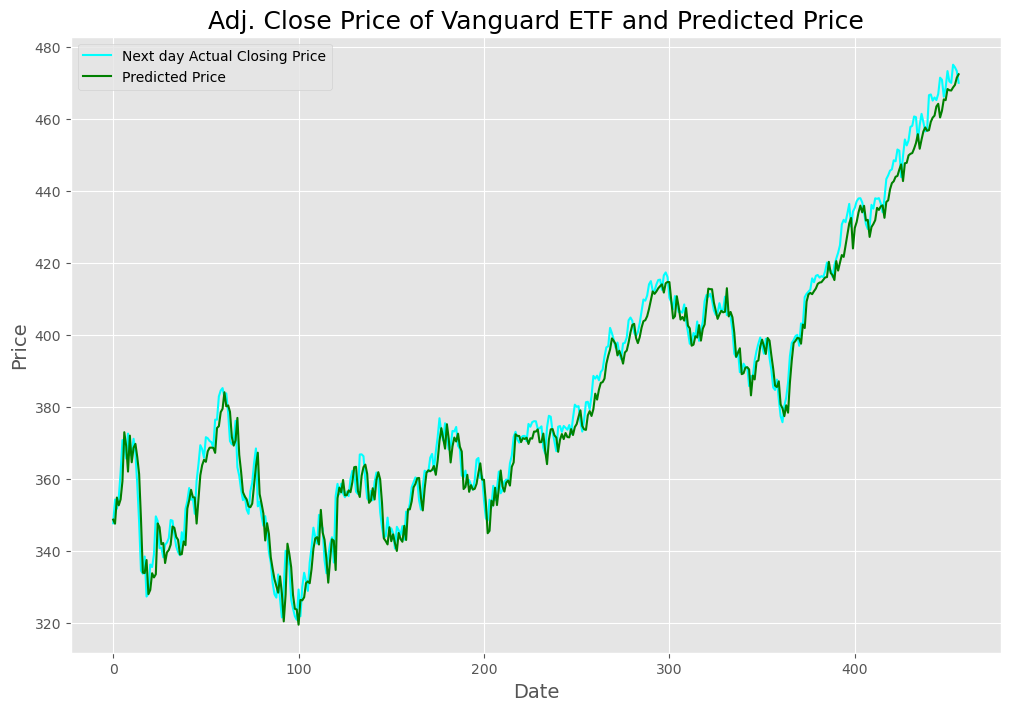

In [355]:
#Plot the Adj. Close price
plt.figure(figsize= (12, 8))
plt.title('Adj. Close Price of Vanguard ETF and Predicted Price' , fontsize = 18)
# plt.subplot(211)
plt.plot(df_final['Target'], label= "Next day Actual Closing Price", color= 'cyan')
plt.plot(df_final['Predicted'], label="Predicted Price", color = 'green', alpha=1)
plt.xlabel('Date', fontsize = 14)
plt.legend(loc = "upper left")
plt.ylabel('Price', fontsize = 14)

## 10. Creating the FBProphet model

In [26]:
# pip install prophet
from prophet import Prophet

In [27]:
df = data.copy()

In [28]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,189.289993,189.720001,187.259995,188.399994,159.705673,1865000
2015-01-05,187.259995,187.410004,184.660004,185.089996,156.899780,2734700
2015-01-06,185.369995,185.880005,182.360001,183.270004,155.357025,2245300
2015-01-07,184.729996,185.910004,184.229996,185.559998,157.298233,2305600
2015-01-08,187.130005,189.050003,187.070007,188.820007,160.061722,1740600
...,...,...,...,...,...,...
2024-03-19,472.200012,475.739990,471.290009,475.600006,475.600006,4550200
2024-03-20,475.540009,480.019989,474.929993,479.750000,479.750000,6179400
2024-03-21,482.619995,483.239990,481.209991,481.350006,481.350006,5044700


### Initialize the FBProphet model and perform the predictions

18:12:14 - cmdstanpy - INFO - Chain [1] start processing
18:12:16 - cmdstanpy - INFO - Chain [1] done processing


MAE: 7.412828455559769
MAPE: 0.02641543935121339
MSE: 121.47128526552873
RMSE: 11.021401238750395


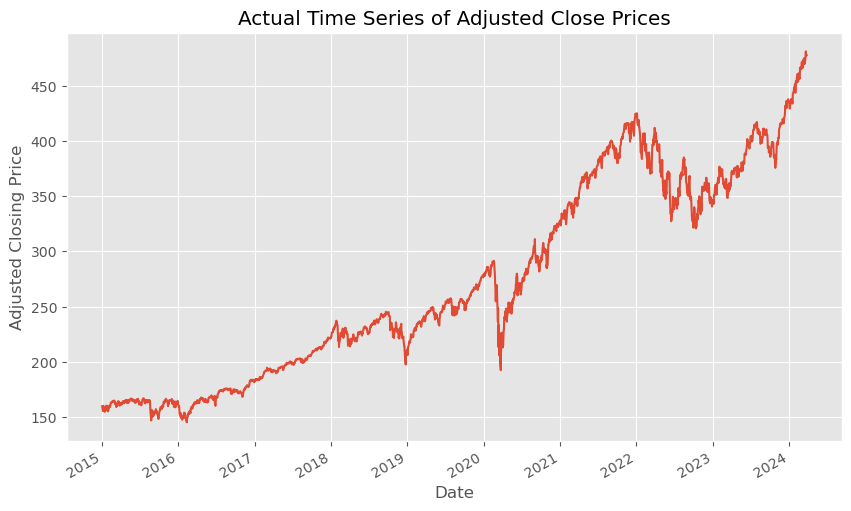

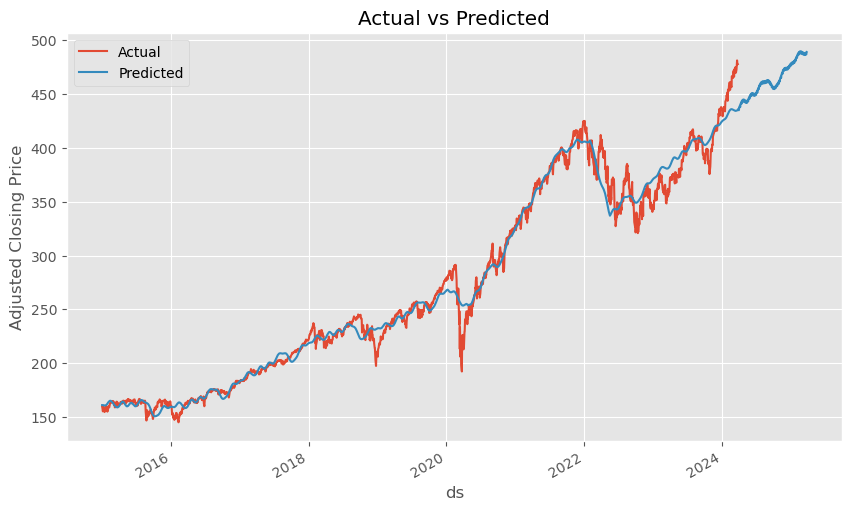

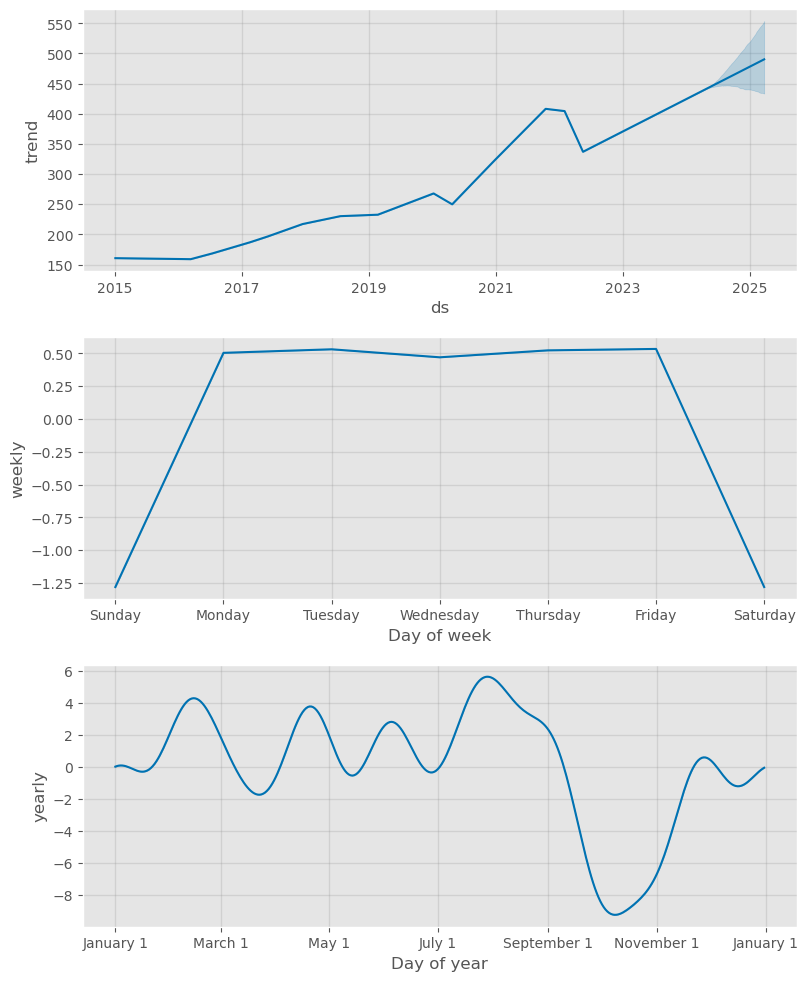

In [37]:
# Set the duration of predictions
period = 365

# Plot the actual time series of Adjusted Close prices
fig, ax1 = plt.subplots(figsize=(10, 6))
df['Adj Close'].plot(ax=ax1)
ax1.set_ylabel('Adjusted Closing Price')
ax1.set_title('Actual Time Series of Adjusted Close Prices')

# Prepare the data for FBProphet
df_prophet = df.reset_index().rename(columns={'Date': 'ds', 'Adj Close': 'y'})

# Initialize the Model
model = Prophet(daily_seasonality=False, yearly_seasonality=True)

# Fit the Model
model.fit(df_prophet)

# Make a DataFrame to hold predictions
future = model.make_future_dataframe(periods=period)  # This value of the periods can be adjusted as per our needs

# Predict
forecast = model.predict(future)

# Plot the actual vs predicted values
fig2, ax2 = plt.subplots(figsize=(10, 6))
df['Adj Close'].plot(ax=ax2, label='Actual')
forecast.set_index('ds')['yhat'].plot(ax=ax2, label='Predicted')
ax2.set_ylabel('Adjusted Closing Price')
ax2.set_title('Actual vs Predicted')
ax2.legend()

# Plotting the components of the model
fig2 = model.plot_components(forecast)
fig2.set_figheight(10)
fig2.set_figwidth(8)
plt.show()

### Download Bank Interest rate

In [98]:
import pandas as pd
import pandas_datareader as pdr
import datetime
start_date = datetime.datetime(2015, 1, 1)
end_date = datetime.datetime.now()

In [107]:
series = 'FEDFUNDS' #USA CPI from FRED

df_bank = pdr.get_data_fred(series, start_date, end_date)
df_bank.reset_index(inplace = True)
df_bank['DATE'] = pd.to_datetime(df_bank['DATE']).dt.strftime('%Y-%m-%d')

In [108]:
type(df_bank['DATE'][0])

str

In [109]:
df_bank= df_bank.rename(columns={"DATE":"Date","FEDFUNDS":'Bank_Interest'})
df_bank

,Date,Bank_Interest
0,2015-01-01,0.11
1,2015-02-01,0.11
2,2015-03-01,0.11
3,2015-04-01,0.12
4,2015-05-01,0.12
...,...,...
105,2023-10-01,5.33
106,2023-11-01,5.33
107,2023-12-01,5.33
108,2024-01-01,5.33


In [110]:
df_bank = df_bank.set_index('Date',drop=True)
df_bank

,Bank_Interest
Date,
2015-01-01,0.11
2015-02-01,0.11
2015-03-01,0.11
2015-04-01,0.12
2015-05-01,0.12
...,...
2023-10-01,5.33
2023-11-01,5.33
2023-12-01,5.33


In [111]:
df_bank_daily = df_bank.copy()

In [112]:
# Update the Bank Interest rate data from monthly to daily data, to be in sync with the ETF data.
df_bank_daily.index = pd.to_datetime(df_bank_daily.index)
df_bank_daily = df_bank_daily.resample('D').ffill()
df_bank_daily

,Bank_Interest
Date,
2015-01-01,0.11
2015-01-02,0.11
2015-01-03,0.11
2015-01-04,0.11
2015-01-05,0.11
...,...
2024-01-28,5.33
2024-01-29,5.33
2024-01-30,5.33


In [114]:
# Join the stock and interest data
# The Bank Interest rate column for the current month will be dislayed as NaN. since the data for current month is not available.

df_combined = data.join(df_bank_daily,how='left')
df_combined

,Open,High,Low,Close,Adj Close,Volume,Bank_Interest
Date,,,,,,,
2015-01-02,189.289993,189.720001,187.259995,188.399994,159.705673,1865000,0.11
2015-01-05,187.259995,187.410004,184.660004,185.089996,156.899780,2734700,0.11
2015-01-06,185.369995,185.880005,182.360001,183.270004,155.357025,2245300,0.11
2015-01-07,184.729996,185.910004,184.229996,185.559998,157.298233,2305600,0.11
2015-01-08,187.130005,189.050003,187.070007,188.820007,160.061722,1740600,0.11
...,...,...,...,...,...,...,...
2024-03-19,472.200012,475.739990,471.290009,475.600006,475.600006,4550200,NaN
2024-03-20,475.540009,480.019989,474.929993,479.750000,479.750000,6179400,NaN
2024-03-21,482.619995,483.239990,481.209991,481.350006,481.350006,5044700,NaN


In [115]:
# We will Forward Fill the Bank Interest column for the current month with the available data from the previous month
df_combined['Bank_Interest'] = df_combined['Bank_Interest'].ffill()

In [116]:
df_combined

,Open,High,Low,Close,Adj Close,Volume,Bank_Interest
Date,,,,,,,
2015-01-02,189.289993,189.720001,187.259995,188.399994,159.705673,1865000,0.11
2015-01-05,187.259995,187.410004,184.660004,185.089996,156.899780,2734700,0.11
2015-01-06,185.369995,185.880005,182.360001,183.270004,155.357025,2245300,0.11
2015-01-07,184.729996,185.910004,184.229996,185.559998,157.298233,2305600,0.11
2015-01-08,187.130005,189.050003,187.070007,188.820007,160.061722,1740600,0.11
...,...,...,...,...,...,...,...
2024-03-19,472.200012,475.739990,471.290009,475.600006,475.600006,4550200,5.33
2024-03-20,475.540009,480.019989,474.929993,479.750000,479.750000,6179400,5.33
2024-03-21,482.619995,483.239990,481.209991,481.350006,481.350006,5044700,5.33


In [117]:
df_combined['Prev Adj Close'] = df_combined['Adj Close'].shift(1)
df_combined

,Open,High,Low,Close,Adj Close,Volume,Bank_Interest,Prev Adj Close
Date,,,,,,,,
2015-01-02,189.289993,189.720001,187.259995,188.399994,159.705673,1865000,0.11,NaN
2015-01-05,187.259995,187.410004,184.660004,185.089996,156.899780,2734700,0.11,159.705673
2015-01-06,185.369995,185.880005,182.360001,183.270004,155.357025,2245300,0.11,156.899780
2015-01-07,184.729996,185.910004,184.229996,185.559998,157.298233,2305600,0.11,155.357025
2015-01-08,187.130005,189.050003,187.070007,188.820007,160.061722,1740600,0.11,157.298233
...,...,...,...,...,...,...,...,...
2024-03-19,472.200012,475.739990,471.290009,475.600006,475.600006,4550200,5.33,472.950012
2024-03-20,475.540009,480.019989,474.929993,479.750000,479.750000,6179400,5.33,475.600006
2024-03-21,482.619995,483.239990,481.209991,481.350006,481.350006,5044700,5.33,479.750000


In [118]:
df_combined = df_combined.dropna()
df_combined

,Open,High,Low,Close,Adj Close,Volume,Bank_Interest,Prev Adj Close
Date,,,,,,,,
2015-01-05,187.259995,187.410004,184.660004,185.089996,156.899780,2734700,0.11,159.705673
2015-01-06,185.369995,185.880005,182.360001,183.270004,155.357025,2245300,0.11,156.899780
2015-01-07,184.729996,185.910004,184.229996,185.559998,157.298233,2305600,0.11,155.357025
2015-01-08,187.130005,189.050003,187.070007,188.820007,160.061722,1740600,0.11,157.298233
2015-01-09,189.300003,189.339996,186.649994,187.229996,158.713867,2525200,0.11,160.061722
...,...,...,...,...,...,...,...,...
2024-03-19,472.200012,475.739990,471.290009,475.600006,475.600006,4550200,5.33,472.950012
2024-03-20,475.540009,480.019989,474.929993,479.750000,479.750000,6179400,5.33,475.600006
2024-03-21,482.619995,483.239990,481.209991,481.350006,481.350006,5044700,5.33,479.750000


### LSTM model: Predict Adj. Close Price of ETF data using Bivariate Analysis

Epoch 1/50
52/52 [==============================] - 5s 32ms/step - loss: 0.0066 - val_loss: 0.0012
Epoch 2/50
52/52 [==============================] - 1s 20ms/step - loss: 3.6907e-04 - val_loss: 0.0013
Epoch 3/50
52/52 [==============================] - 1s 20ms/step - loss: 3.4358e-04 - val_loss: 0.0017
Epoch 4/50
52/52 [==============================] - 1s 20ms/step - loss: 3.5549e-04 - val_loss: 0.0016
Epoch 5/50
52/52 [==============================] - 1s 21ms/step - loss: 3.2835e-04 - val_loss: 0.0013
Epoch 6/50
52/52 [==============================] - 1s 20ms/step - loss: 3.0995e-04 - val_loss: 0.0010
Epoch 7/50
52/52 [==============================] - 1s 20ms/step - loss: 2.9012e-04 - val_loss: 9.2264e-04
Epoch 8/50
52/52 [==============================] - 1s 21ms/step - loss: 2.8552e-04 - val_loss: 8.6939e-04
Epoch 9/50
52/52 [==============================] - 1s 21ms/step - loss: 2.7504e-04 - val_loss: 8.8440e-04
Epoch 10/50
52/52 [==============================] - 1s 21ms/step

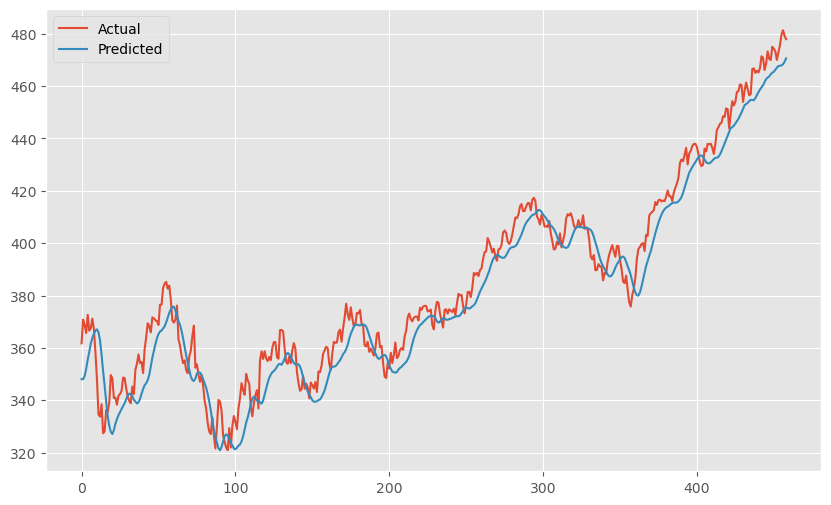

In [125]:
# Features and Target
features = df_combined[['Prev Adj Close', 'Bank_Interest']]  # Including Previous Day's Adj Close and Interest
target = df_combined['Adj Close']

# Scaling the features and target
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

# Function to create dataset for LSTM
def create_dataset(X, y, time_step):
    Xs, ys = [], []
    for i in range(len(X) - time_step):
        v = X[i:(i + time_step)]
        Xs.append(v)
        ys.append(y[i + time_step])
    return np.array(Xs), np.array(ys)

time_steps = 30  # Using 30 days previous timestep
X, y = create_dataset(scaled_features, scaled_target, time_steps)

# Splitting the dataset into training and test sets
split = int(len(X) * 0.8)  # 80% for training, 20% for testing
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50),
    Dense(1)
])


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Adding Early Stopping callback with patience of 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1,callbacks=[early_stopping])

# Prediction
y_pred = model.predict(X_test)

# Inverse scaling for plotting and evaluation
y_test_inv = scaler_target.inverse_transform(y_test)
y_pred_inv = scaler_target.inverse_transform(y_pred)

In [128]:
# Calculate error metrics

mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
r_square = r2_score(y_test_inv, y_pred_inv)

print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.4f}')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R-Square:{r_square:.4f}')

MAE: 7.6038
MAPE: 0.0200
MSE: 83.8077
RMSE: 9.1547
R-Square:0.9405


In [167]:
# Plot the Actual vs Predicted charts
import plotly.graph_objects as go

# Create traces
chart1 = go.Scatter(
    y = y_test_inv.flatten(),
    mode = 'lines',
    name = 'Actual'
)
chart2 = go.Scatter(
    y = y_pred_inv.flatten(),
    mode = 'lines',
    name = 'Predicted'
)

# Layout
layout = go.Layout(
    title = f'Actual vs Forecasted Adjusted Close Price of {symbol} ETF',
    xaxis_title = 'Time',
    yaxis_title = 'Adjusted Close Price',
    width=1000,
    height=600
)

# Figure
fig = go.Figure(data=[chart1, chart2], layout=layout)

# Show the plot
fig.show()

### FB- Prophet model: Predict Adj. CLose Price of ETF data using Bivariate Analysis

In [154]:
from prophet import Prophet
import plotly.graph_objects as go

df_prophet = df_combined.copy()

# Set the prediction periods as desired
period = 365

# Reset the index of the dataframe to make Date as a column
df_prophet = df_prophet.reset_index()

# Prepare the dataset for Prophet
# Prophet requires the dataframe to have two columns: "ds" and "y"
prophet_df = df_prophet.rename(columns={'Date': 'ds', 'Adj Close': 'y'})

In [155]:
prophet_df

,ds,Open,High,Low,Close,y,Volume,Bank_Interest,Prev Adj Close
0,2015-01-05,187.259995,187.410004,184.660004,185.089996,156.899780,2734700,0.11,159.705673
1,2015-01-06,185.369995,185.880005,182.360001,183.270004,155.357025,2245300,0.11,156.899780
2,2015-01-07,184.729996,185.910004,184.229996,185.559998,157.298233,2305600,0.11,155.357025
3,2015-01-08,187.130005,189.050003,187.070007,188.820007,160.061722,1740600,0.11,157.298233
4,2015-01-09,189.300003,189.339996,186.649994,187.229996,158.713867,2525200,0.11,160.061722
...,...,...,...,...,...,...,...,...,...
2316,2024-03-19,472.200012,475.739990,471.290009,475.600006,475.600006,4550200,5.33,472.950012
2317,2024-03-20,475.540009,480.019989,474.929993,479.750000,479.750000,6179400,5.33,475.600006
2318,2024-03-21,482.619995,483.239990,481.209991,481.350006,481.350006,5044700,5.33,479.750000
2319,2024-03-22,479.869995,480.320007,478.820007,479.179993,479.179993,5876800,5.33,481.350006


In [159]:
# Initialize the Prophet model and add 'Bank_Interest' as an additional regressor
model_fbp = Prophet(daily_seasonality=False, yearly_seasonality=True)
model_fbp.add_regressor('Bank_Interest')

# Fit the model
model_fbp.fit(prophet_df)

# Make a future dataframe for predictions
future = model_fbp.make_future_dataframe(periods=period)

# Update the future values of the regressor 'Bank_Interest'. 
# Since we don't have future values of 'Bank_Interest', we'll use the last available value for our scenario.

future['Bank_Interest'] = df_prophet['Bank_Interest'].iloc[-1]

# Predict
forecast = model_fbp.predict(future)

14:57:43 - cmdstanpy - INFO - Chain [1] start processing
14:57:44 - cmdstanpy - INFO - Chain [1] done processing


In [160]:
# Calculate and print the metrics
y_true = prophet_df['y']
y_pred = forecast['yhat'][:len(y_true)]

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_true, y_pred)
r_square = r2_score(y_test_inv, y_pred_inv)

print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.4f}')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R-Square:{r_square:.4f}')

MAE: 73.3496
MAPE: 0.3178
MSE: 6356.4043
RMSE: 79.7271
R-Square:0.9405


In [166]:
# Plotting the actual and forecasted values
fig = go.Figure()

# Actual data
fig.add_trace(go.Scatter(x=prophet_df['ds'], y=prophet_df['y'], name='Actual'))

# Forecasted data
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Forecast'))

# Plot components
fig.update_layout(title=f'Actual vs Forecasted Adjusted Close Price of {symbol} ETF',
                  xaxis_title='Date',
                  yaxis_title='Adjusted Close Price',
                  width=1000, height=600)

fig.show()

In [162]:
# Extract and plot the model components
trend = forecast[['ds', 'trend']]
yearly = forecast[['ds', 'yearly']]

# Plot Trend Component
fig_trend = go.Figure()
fig_trend.add_trace(go.Scatter(x=trend['ds'], y=trend['trend'], mode='lines', name='Trend'))
fig_trend.update_layout(title='Trend Component', xaxis_title='Date', yaxis_title='Trend', width=1000, height=400)
fig_trend.show()

# Plot Yearly Seasonality Component
fig_yearly = go.Figure()
fig_yearly.add_trace(go.Scatter(x=yearly['ds'], y=yearly['yearly'], mode='lines', name='Yearly Seasonality'))
fig_yearly.update_layout(title='Yearly Seasonality Component', xaxis_title='Date', yaxis_title='Yearly Seasonality', width=1000, height=400)
fig_yearly.show()

In [165]:
# Displaying all the forecasted values
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Bank_Interest,Bank_Interest_lower,Bank_Interest_upper,additive_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-05,137.173681,49.714975,74.233401,137.173681,137.173681,-72.612599,-72.612599,-72.612599,-75.881556,...,-3.652864,-3.652864,-3.652864,0.383906,0.383906,0.383906,0.0,0.0,0.0,61.292124
1,2015-01-06,137.180193,49.765636,72.952823,137.180193,137.180193,-72.612599,-72.612599,-72.612599,-75.811481,...,-3.627731,-3.627731,-3.627731,0.428849,0.428849,0.428849,0.0,0.0,0.0,61.368712
2,2015-01-07,137.186705,50.149937,72.838180,137.186705,137.186705,-72.612599,-72.612599,-72.612599,-75.823565,...,-3.671709,-3.671709,-3.671709,0.460743,0.460743,0.460743,0.0,0.0,0.0,61.363140
3,2015-01-08,137.193217,49.281800,73.172899,137.193217,137.193217,-72.612599,-72.612599,-72.612599,-75.781953,...,-3.649687,-3.649687,-3.649687,0.480333,0.480333,0.480333,0.0,0.0,0.0,61.411264
4,2015-01-09,137.199729,49.725836,73.483796,137.199729,137.199729,-72.612599,-72.612599,-72.612599,-75.766201,...,-3.642419,-3.642419,-3.642419,0.488816,0.488816,0.488816,0.0,0.0,0.0,61.433528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,2025-03-21,636.213243,499.235522,616.945930,577.770614,697.648223,-72.612599,-72.612599,-72.612599,-79.308514,...,-3.642419,-3.642419,-3.642419,-3.053497,-3.053497,-3.053497,0.0,0.0,0.0,556.904729
2682,2025-03-22,636.491613,510.540573,630.141695,577.887486,698.219803,-72.612599,-72.612599,-72.612599,-66.468966,...,9.122209,9.122209,9.122209,-2.978576,-2.978576,-2.978576,0.0,0.0,0.0,570.022646
2683,2025-03-23,636.769983,511.425833,632.957719,578.039594,698.787173,-72.612599,-72.612599,-72.612599,-66.366777,...,9.122201,9.122201,9.122201,-2.876379,-2.876379,-2.876379,0.0,0.0,0.0,570.403206
2684,2025-03-24,637.048353,497.486234,621.231691,578.191702,699.353887,-72.612599,-72.612599,-72.612599,-79.013322,...,-3.652864,-3.652864,-3.652864,-2.747859,-2.747859,-2.747859,0.0,0.0,0.0,558.035031


### XGBoost model: Predict Adj. CLose Price of ETF data using Bivariate Analysis

In [221]:
import xgboost as xgb
import os
import xgboost as xgb
from xgboost import XGBRegressor
from finta import TA

In [239]:
# Get the data for the model
df_xgb = df_combined.copy()

In [240]:
df_xgb

,Open,High,Low,Close,Adj Close,Volume,Bank_Interest,Prev Adj Close
Date,,,,,,,,
2015-01-05,187.259995,187.410004,184.660004,185.089996,156.899780,2734700,0.11,159.705673
2015-01-06,185.369995,185.880005,182.360001,183.270004,155.357025,2245300,0.11,156.899780
2015-01-07,184.729996,185.910004,184.229996,185.559998,157.298233,2305600,0.11,155.357025
2015-01-08,187.130005,189.050003,187.070007,188.820007,160.061722,1740600,0.11,157.298233
2015-01-09,189.300003,189.339996,186.649994,187.229996,158.713867,2525200,0.11,160.061722
...,...,...,...,...,...,...,...,...
2024-03-19,472.200012,475.739990,471.290009,475.600006,475.600006,4550200,5.33,472.950012
2024-03-20,475.540009,480.019989,474.929993,479.750000,479.750000,6179400,5.33,475.600006
2024-03-21,482.619995,483.239990,481.209991,481.350006,481.350006,5044700,5.33,479.750000


In [241]:
# Prepare the features and target
X = df_xgb[['Prev Adj Close', 'Bank_Interest']]
y = df_xgb['Adj Close']

# Split the data into training and test sets
len_train = int(len(df_xgb)*0.80)
len_test = len(df_xgb) - len_train

# Feature dataset
X_train = X[:len_train]
X_test = X[len_train:]

#Target dataset
y_train = y[:len_train]
y_test = y[len_train:]

In [242]:

# Train the XGBoost model
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                         max_depth=5, alpha=10, n_estimators=100)
model_xgb.fit(X_train, y_train)

# Make predictions
y_pred = model_xgb.predict(X_test)

In [210]:
# Calculate and print the metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
r_square = r2_score(y_test, y_pred)

print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.4f}')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R-Square:{r_square:.4f}')

MAE: 61.6480
MAPE: 0.1583
MSE: 4172.5897
RMSE: 64.5956
R-Square:-1.9707


In [211]:
# Plotting actual vs predicted using Plotly
fig_xgb = go.Figure()

# Actual data
fig_xgb.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name='Actual'))

# Predicted data
fig_xgb.add_trace(go.Scatter(x=y_test.index, y=y_pred, mode='lines', name='Predicted'))

fig_xgb.update_layout(title=f'Actual vs Forecasted Adjusted Close Price of {symbol} ETF',
                  xaxis_title='Date',
                  yaxis_title='Adjusted Close Price',
                  width=1000, height=600)

fig_xgb.show()

In [243]:
# create different statistical metrics for the model.

df_xgb['EMA_9'] = df_xgb['Adj Close'].ewm(9).mean().shift()
df_xgb['SMA_5'] = df_xgb['Adj Close'].rolling(5).mean().shift()
df_xgb['SMA_10'] = df_xgb['Adj Close'].rolling(10).mean().shift()
df_xgb['SMA_15'] = df_xgb['Adj Close'].rolling(15).mean().shift()
df_xgb['SMA_30'] = df_xgb['Adj Close'].rolling(30).mean().shift()

In [244]:
df_xgb

,Open,High,Low,Close,Adj Close,Volume,Bank_Interest,Prev Adj Close,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30
Date,,,,,,,,,,,,,
2015-01-05,187.259995,187.410004,184.660004,185.089996,156.899780,2734700,0.11,159.705673,NaN,NaN,NaN,NaN,NaN
2015-01-06,185.369995,185.880005,182.360001,183.270004,155.357025,2245300,0.11,156.899780,156.899780,NaN,NaN,NaN,NaN
2015-01-07,184.729996,185.910004,184.229996,185.559998,157.298233,2305600,0.11,155.357025,156.087804,NaN,NaN,NaN,NaN
2015-01-08,187.130005,189.050003,187.070007,188.820007,160.061722,1740600,0.11,157.298233,156.534457,NaN,NaN,NaN,NaN
2015-01-09,189.300003,189.339996,186.649994,187.229996,158.713867,2525200,0.11,160.061722,157.560123,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-19,472.200012,475.739990,471.290009,475.600006,475.600006,4550200,5.33,472.950012,468.306587,473.114001,471.399002,470.290666,464.751668
2024-03-20,475.540009,480.019989,474.929993,479.750000,479.750000,6179400,5.33,475.600006,469.035929,473.228003,472.344003,470.935333,465.517669
2024-03-21,482.619995,483.239990,481.209991,481.350006,481.350006,5044700,5.33,479.750000,470.107336,474.316003,473.457004,471.904667,466.375002


In [275]:
# Plot the chart using Plotly
df_plot = df_xgb[['Adj Close','EMA_9','SMA_5','SMA_10','SMA_15','SMA_30']]

# Create a Plotly figure
fig_xgb = go.Figure()

# Loop through each column in df_plot and add it as a trace to the figure
for column in df_plot.columns:
    fig_xgb.add_trace(go.Scatter(x=df_plot.index, y=df_plot[column], mode='lines', name=column))

# Update layout with title, labels, and dimensions
fig_xgb.update_layout(title='ETF Data Over Time with different statistics',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  width=1000, height=600)

# Show the plot
fig_xgb.show()


In [247]:
# Calculate the Technical analysis value for the dataset.

df_xgb['RSI'] = TA.RSI(df_xgb)
df_xgb['ATR'] = TA.ATR(df_xgb)
df_xgb['BBWidth'] = TA.BBWIDTH(df_xgb)
df_xgb['Williams'] = TA.WILLIAMS(df_xgb)

`RSI (Relative Strength Index)`: RSI is a momentum oscillator that measures the speed and change of price movements. It oscillates between 0 and 100 and is typically used to identify overbought or oversold conditions in a traded asset. An RSI above 70 is generally considered overbought, whereas an RSI below 30 is considered oversold. This can signal potential reversals in price direction.

`ATR (Average True Range)`: ATR is a volatility indicator that measures the degree of price volatility by decomposing the entire range of an asset for that period. It is not a directional indicator but rather gives traders an idea of how much an asset moves, on average, over a given period. This can be useful for setting stop-loss orders or for understanding the volatility of an asset.

`BBWidth (Bollinger Band Width)`: Bollinger Bands are a popular volatility indicator that consists of a middle line (typically a simple moving average) with two bands (upper and lower) plotted two standard deviations away from the middle line. The BBWidth measures the distance (or width) between these upper and lower bands. A widening BBWidth indicates increasing volatility, while a narrowing BBWidth suggests decreasing volatility.

`Williams %R (Williams Percent Range)`: Williams %R is a momentum indicator that measures overbought and oversold levels. It is similar to the RSI but uses a different calculation method. The indicator moves between 0 and -100, with readings above -20 typically indicating overbought conditions and readings below -80 indicating oversold conditions. This can signal potential reversals in the market.

Create a new Target column which is the Adj. Close price for next day

In [252]:
df_xgb['Target'] = df_xgb['Adj Close'].shift(-1)

In [254]:
df_xgb

,Open,High,Low,Close,Adj Close,Volume,Bank_Interest,Prev Adj Close,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,ATR,BBWidth,Williams,Target
Date,,,,,,,,,,,,,,,,,,
2015-01-05,187.259995,187.410004,184.660004,185.089996,156.899780,2734700,0.11,159.705673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155.357025
2015-01-06,185.369995,185.880005,182.360001,183.270004,155.357025,2245300,0.11,156.899780,156.899780,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,157.298233
2015-01-07,184.729996,185.910004,184.229996,185.559998,157.298233,2305600,0.11,155.357025,156.087804,NaN,NaN,NaN,NaN,57.537723,NaN,NaN,NaN,160.061722
2015-01-08,187.130005,189.050003,187.070007,188.820007,160.061722,1740600,0.11,157.298233,156.534457,NaN,NaN,NaN,NaN,77.438987,NaN,NaN,NaN,158.713867
2015-01-09,189.300003,189.339996,186.649994,187.229996,158.713867,2525200,0.11,160.061722,157.560123,NaN,NaN,NaN,NaN,62.141356,NaN,NaN,NaN,157.535614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-19,472.200012,475.739990,471.290009,475.600006,475.600006,4550200,5.33,472.950012,468.306587,473.114001,471.399002,470.290666,464.751668,64.149765,4.642848,0.038088,-5.718809,479.750000
2024-03-20,475.540009,480.019989,474.929993,479.750000,479.750000,6179400,5.33,475.600006,469.035929,473.228003,472.344003,470.935333,465.517669,68.084548,4.719278,0.034462,-1.691661,481.350006
2024-03-21,482.619995,483.239990,481.209991,481.350006,481.350006,5044700,5.33,479.750000,470.107336,474.316003,473.457004,471.904667,466.375002,69.475573,4.622849,0.039255,-9.853936,479.179993


In [255]:
# dropping the N/A datas from the dataframe.
df_xgb = df_xgb.dropna()
df_xgb

,Open,High,Low,Close,Adj Close,Volume,Bank_Interest,Prev Adj Close,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,ATR,BBWidth,Williams,Target
Date,,,,,,,,,,,,,,,,,,
2015-02-18,192.279999,192.779999,192.000000,192.740005,163.384689,1863000,0.11,163.350815,159.935017,162.094513,160.744972,159.312364,158.485576,65.645652,2.020000,0.060535,-1.226988,163.274490
2015-02-19,192.089996,192.970001,191.889999,192.610001,163.274490,1017600,0.11,163.384689,160.293668,162.616693,161.164584,159.696652,158.701740,65.064788,1.860001,0.063086,-3.130440,164.266281
2015-02-20,192.130005,193.820007,191.449997,193.779999,164.266281,1374000,0.11,163.274490,160.602349,163.094791,161.627432,160.212051,158.965655,67.824148,1.832858,0.067793,-0.323956,164.223923
2015-02-23,193.490005,193.729996,193.029999,193.729996,164.223923,1497700,0.11,164.266281,160.980426,163.472855,162.028387,160.692975,159.197923,67.578480,1.615716,0.071566,-1.120939,164.707123
2015-02-24,193.690002,194.490005,193.429993,194.300003,164.707123,1244200,0.11,164.223923,161.314055,163.700040,162.470038,161.299926,159.336663,68.958776,1.493574,0.075581,-2.423497,164.529083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-18,473.950012,475.279999,472.500000,472.950012,472.950012,3939100,5.33,470.010010,467.790651,472.523999,471.191000,469.765332,464.129335,61.322330,4.454993,0.043100,-27.369103,475.600006
2024-03-19,472.200012,475.739990,471.290009,475.600006,475.600006,4550200,5.33,472.950012,468.306587,473.114001,471.399002,470.290666,464.751668,64.149765,4.642848,0.038088,-5.718809,479.750000
2024-03-20,475.540009,480.019989,474.929993,479.750000,479.750000,6179400,5.33,475.600006,469.035929,473.228003,472.344003,470.935333,465.517669,68.084548,4.719278,0.034462,-1.691661,481.350006


In [257]:
# Select only the necessary columns for our model
df_xgb_final = df_xgb.drop(['Open','High','Low','Close','Volume','Prev Adj Close'],axis=1)
df_xgb_final

,Adj Close,Bank_Interest,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,ATR,BBWidth,Williams,Target
Date,,,,,,,,,,,,
2015-02-18,163.384689,0.11,159.935017,162.094513,160.744972,159.312364,158.485576,65.645652,2.020000,0.060535,-1.226988,163.274490
2015-02-19,163.274490,0.11,160.293668,162.616693,161.164584,159.696652,158.701740,65.064788,1.860001,0.063086,-3.130440,164.266281
2015-02-20,164.266281,0.11,160.602349,163.094791,161.627432,160.212051,158.965655,67.824148,1.832858,0.067793,-0.323956,164.223923
2015-02-23,164.223923,0.11,160.980426,163.472855,162.028387,160.692975,159.197923,67.578480,1.615716,0.071566,-1.120939,164.707123
2015-02-24,164.707123,0.11,161.314055,163.700040,162.470038,161.299926,159.336663,68.958776,1.493574,0.075581,-2.423497,164.529083
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-18,472.950012,5.33,467.790651,472.523999,471.191000,469.765332,464.129335,61.322330,4.454993,0.043100,-27.369103,475.600006
2024-03-19,475.600006,5.33,468.306587,473.114001,471.399002,470.290666,464.751668,64.149765,4.642848,0.038088,-5.718809,479.750000
2024-03-20,479.750000,5.33,469.035929,473.228003,472.344003,470.935333,465.517669,68.084548,4.719278,0.034462,-1.691661,481.350006


In [258]:
# create function for splitting the data into train and test
def data_split(data,perc):
    data = data.values
    n = int(len(data)*(1-perc))
    return data[:n],data[n:]

In [259]:
train,test = data_split(df_xgb_final,0.20)

In [260]:
print(len(df_xgb_final))
print(len(train))
print(len(test))

2290
1832
458


In [261]:
# Getting the data ready for training the model
X = train[:,:-1]
y = train[:,-1]

In [262]:
# fit the model with the training data and hyperparameters
model_xgb = XGBRegressor(objective='reg:squarederror', n_estimators=350, learning_rate=0.05, colsample_bytree=0.7,max_depth=3,gamma=5)
model_xgb.fit(X,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=5, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=350, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [264]:
#Create function for training the model and predicting a single value at a time.

def xgb_predict(train, val):
  train = np.array(train)
  X, y = train[:, :-1], train[:,-1]
  model = XGBRegressor(objective='reg:squarederror', n_estimators=350, learning_rate=0.05, colsample_bytree=0.7,max_depth=3,gamma=5)
  model.fit(X,y)
  val = np.array(val).reshape(1, -1)
  pred = model.predict(val)
  return pred[0]

In [ ]:
#Mean Absolute Percentage Error(MAPE)
def mean_abs(actual, pred):
  actual, pred = np.array(actual), np.array(pred)
  ma_error = np.mean(np.abs((actual-pred)/actual))*100
  return ma_error

In [265]:
# This function is for the overall model which utilizes the other functions for predictions and calculating the error metrics.

def validate(data, perc):
  predictions = []
  train, test = data_split(data, perc)
  history = [x for x in train]

  for i in range(len(test)):
    X_test, y_test = test[i, :-1], test[i, -1]
    pred = xgb_predict(history, X_test)
    predictions.append(pred)

    history.append(test[i])

  mse = mean_squared_error(test[:, -1], predictions)
  rmse = mean_squared_error(test[:, -1], predictions, squared=False)
  mae = mean_absolute_error(test[:, -1], predictions)
  # MAPE = mean_abs(test[:,-1], predictions)
  mape = np.mean(np.abs((test[:, -1]-predictions)/test[:, -1]))*100
  r_sq = r2_score(test[:,-1], predictions)
  return mse,rmse,mae,mape,r_sq, test[:, -1], predictions

In [266]:
mse,rmse,mae,mape,r2, y, pred = validate(df_xgb_final, 0.2)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAE = {}'.format(mae))
print('MAPE = {:.2f} %'.format(mape))
print('R-Squared Score = {}'.format(r2))
# print(y)
# print(pred)

MSE = 22.17833625787145
RMSE = 4.709388098030513
MAE = 3.7114694920169216
MAPE = 0.98 %
R-Squared Score = 0.9842671369813137


In [268]:
# Add test and pred array.
pred = np.array(pred)
test_pred = np.c_[test,pred]

In [269]:
df_xgb_final

,Adj Close,Bank_Interest,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,ATR,BBWidth,Williams,Target
Date,,,,,,,,,,,,
2015-02-18,163.384689,0.11,159.935017,162.094513,160.744972,159.312364,158.485576,65.645652,2.020000,0.060535,-1.226988,163.274490
2015-02-19,163.274490,0.11,160.293668,162.616693,161.164584,159.696652,158.701740,65.064788,1.860001,0.063086,-3.130440,164.266281
2015-02-20,164.266281,0.11,160.602349,163.094791,161.627432,160.212051,158.965655,67.824148,1.832858,0.067793,-0.323956,164.223923
2015-02-23,164.223923,0.11,160.980426,163.472855,162.028387,160.692975,159.197923,67.578480,1.615716,0.071566,-1.120939,164.707123
2015-02-24,164.707123,0.11,161.314055,163.700040,162.470038,161.299926,159.336663,68.958776,1.493574,0.075581,-2.423497,164.529083
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-18,472.950012,5.33,467.790651,472.523999,471.191000,469.765332,464.129335,61.322330,4.454993,0.043100,-27.369103,475.600006
2024-03-19,475.600006,5.33,468.306587,473.114001,471.399002,470.290666,464.751668,64.149765,4.642848,0.038088,-5.718809,479.750000
2024-03-20,479.750000,5.33,469.035929,473.228003,472.344003,470.935333,465.517669,68.084548,4.719278,0.034462,-1.691661,481.350006


In [270]:
## Combine the test dataset with the predicted values to create a dataframe

df_final = pd.DataFrame(test_pred,columns=['Adj Close','Bank_Interest','EMA_9','SMA_5','SMA_10','SMA_15','SMA_30','RSI','ATR','BBWidth','Williams','Target','Predicted'])
df_final

,Adj Close,Bank_Interest,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,ATR,BBWidth,Williams,Target,Predicted
0,361.736176,0.77,360.271505,351.216089,353.648972,355.694657,369.320388,47.781498,9.680716,0.106829,-12.015533,370.807281,362.298645
1,370.807281,0.77,360.417972,354.038416,354.795959,355.174733,368.186986,53.933375,9.380716,0.108558,-0.186908,368.748352,371.672729
2,368.748352,0.77,361.456903,358.657477,356.023566,355.414296,367.516205,52.423699,9.067858,0.107774,-9.579975,365.659912,366.886597
3,365.659912,1.21,362.186048,361.545856,357.173477,356.306517,366.774526,50.155802,8.885716,0.104418,-19.190108,372.604065,364.473541
4,372.604065,1.21,362.533435,364.327399,357.299731,356.931974,365.721737,54.881978,8.872142,0.091555,-0.264851,366.572845,372.877197
...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,472.950012,5.33,467.790651,472.523999,471.191000,469.765332,464.129335,61.322330,4.454993,0.043100,-27.369103,475.600006,471.164215
454,475.600006,5.33,468.306587,473.114001,471.399002,470.290666,464.751668,64.149765,4.642848,0.038088,-5.718809,479.750000,472.507965
455,479.750000,5.33,469.035929,473.228003,472.344003,470.935333,465.517669,68.084548,4.719278,0.034462,-1.691661,481.350006,474.901215
456,481.350006,5.33,470.107336,474.316003,473.457004,471.904667,466.375002,69.475573,4.622849,0.039255,-9.853936,479.179993,476.367340


In [276]:
# Create plot for actual and predicted values
from plotly.subplots import make_subplots

fig_xgb_f = make_subplots(rows=1, cols=1)

# Add traces for actual and predicted prices
fig_xgb_f.add_trace(go.Scatter(x=df_final.index, y=df_final['Target'], name="Next day Actual Closing Price", line=dict(color='cyan')), row=1, col=1)
fig_xgb_f.add_trace(go.Scatter(x=df_final.index, y=df_final['Predicted'], name="Predicted Price", line=dict(color='green')), row=1, col=1)

# Update layout with titles and axis labels
fig_xgb_f.update_layout(
    title_text=f'Actual vs Forecasted Adjusted Close Price of {symbol} ETF',
    title_font_size=18,
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis=dict(titlefont=dict(size=14)),
    yaxis=dict(titlefont=dict(size=14)),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    width=1000,
    height=600
)

fig_xgb_f.show()